In [1]:
# NECESSARY PYTHON IMPORTS
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import display 
import ipywidgets as widgets 
from ipywidgets import interact, Layout

from copy import copy

class color: # https://stackoverflow.com/a/17303428 : how to use formatting for printing in python
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

epsilon = np.finfo(float).eps # to take care of binning issues due to machine precision

def hideAxes(h_ax): # hack as RISE.js renders weirdly, create extra axes and then make them invisible
    if not isinstance(h_ax, (list, np.ndarray)):
        h_ax = [h_ax]
    [cur_ax.axis('off') for cur_ax in h_ax]
    
    plt.show()
    
# default size of figures generated in the Ipython notebook
plt.rcParams['figure.figsize'] = [14, 5]

# <center>Spike train analysis using Python</center>
<br/>
<br/>
<img src="images/spike_train.gif" alt="cortical extracellular recording M8T_09-02-10_001" width=70% style="margin-left:auto; margin-right:auto">  
<center><span style="color:LightSlateGray">Dr. Marcus Jeschke</span></center>
<center><span style="color:LightSlateGray">Deutsches Primatenzentrum/Universitätsmedizin Göttingen</span></center>
<br/>

<h5>Lehrprobe - Oldenburg W2-Neurobiologie des Hörens; 2.11.2021<h5>

#### Intro: Reminder - What are spike trains?
- sequence of action potentials (or spikes) from neurons recorded electrically (via: pipettes/electrodes/electrode arrays) or optically (2PM)
<h5> From raw data to neuronal spike trains</h5>
<img src="images/Quiroga_PastPresentFutureSpikeSorting_Fig01.png" alt="From raw data recorded with metal electrodes to neuronal spike trains" width=45% style="margin-left:auto; margin-right:auto">
<div style="text-align: right;font-size:10pt">Rey et al. 2015 <em>Brain. Res. Bull</em> http://dx.doi.org/10.1016/j.brainresbull.2015.04.007</div>



Neurons represent and transmit information by firing series of action potentials, i.e. spike trains

Only action potentials can be transmitted over larger distances other subthreshold fluctuations are severely attenuated and eventually die out. Action potentials on the other hand are regenerative processes and actively created.

We will not go into how to go from the actually recorded data to the spike trains – filtering, identification, sorting
single units vs. multi units.

#### The "central task" for the analysis of spike trains

- How does an animal/human make sense of the incoming spike trains to figure something out about the world in order to act?
- What properties of the spike trains tell us something about the world (i.e. stimuli)? Are some of them better or worse?

<img src="images/StimuliToNeuron.png" width=40% style="margin-left:auto; margin-right:auto">
<br/>
<center><strong> The task is to understand something about the neural code. </strong></center>


```From Dayan and Abbott: Neural encoding, the subject of chapters 1 and 2, refers to the map from stimulus to response. ```
We could measure the response of a neuron to a lot of different stimuli and predict how it would respond to other stimuli

```Neural decoding refers to the reverse map, from response to stimulus, and the challenge is to reconstruct a stimulus, or certain aspects of that stimulus, from the spike sequences it evokes.```

### Outline
1. Firing rates
2. Tuning curves
3. Statistics of spike trains
    - Poisson processes
    - Fano Factor

We will first look at how to estimate and calculate firing rates from spike trains.
Extend the firing rates to the construction of tuning curves
and will end with a description of statistical properties of spike trains introducing Poisson processes as simple model of neuronal firing dynamics and Fano factor to describe neuronal variability.

### Disclaimer

This lecture is prepared as an interactive Jupyter notebook.

GitHub repository: https://github.com/JeschkeM/LehrprobeUOL
<br/>
The notebook can be viewed via https://nbviewer.org/
<br/>
Working along requires a Jupyter http://jupyter.org or Anaconda https://www.anaconda.com/products/individual installation.

The Python code shown is not a 'best practice' example of how to write Python code and functions. Rather, for readibility and conciseness I have not created proper doc strings, error handling etc.
In the Github repository, some best practice examples are shown.




The code also tries to avoid using external libraries (requires *```numpy```* and *```matplotlib```*) as much as possible and instead generates code from first principles for illustrating concepts.

Notable libraries include:
- https://briansimulator.org/getting-started/<div style="float:right;"><img src="images/brian_logo_big.webp" width=120 style="margin-left:auto; margin-right:auto"></div>
<br/>
<br/>
- https://elephant.readthedocs.io/en/latest/<div style="float:right;"><img src="images/elephant_logo_sidebar.png" width=120 style="margin-left:auto; margin-right:auto"></div>
<br/>
<br/>
- https://pythonhosted.org/neuronpy/index.html 
<br/>
&#8205; 

### 1. Firing rates

Spike train: $\{ t(i) \} = \{t_{1}, t_{2}, ... , t_{n}\}$ stands for a number of spikes $n$ occuring at times $t(i)$ 

Could like e.g. like this:

*```
[0.1411, 0.1789, 0.5409, 0.5922, 0.7114, 0.9662, 1.2608, 1.3203, 1.3683, 
1.8849, 1.9083, 1.9509, 2.4425, 2.9103, 2.9317, 3.0405, 4.2415, 4.3468]```*
 
or in a binary format (binned spike train): *```00000000110000000000000000001010000010000000000001```*
<br/>
&#8205; 

Let us load our first spike train and look at it:

*```
trials_spike_times = np.loadtxt('data' + '/' + 'M13W1671_trials_spike_times.txt', delimiter = ',',skiprows = 1) 
```*


Stimulus | Repetition | TrialNumber | Spike time [s]
--- | --- | --- | ---
18. | 1.  | 119. | **-0.212595** 
18. | 1.  | 119. |  **-0.069675**  
18. | 1.  | 119. |  **0.299101**
...
3.  | 7.  | 21. | **0.237816**   
3.  | 7.  | 21. |**0.271716** 
3.  | 7.  | 21. | **0.541293**  

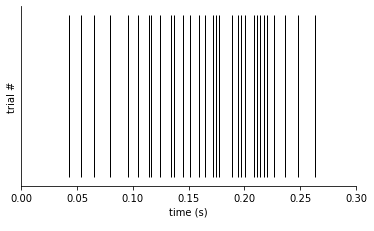

In [2]:
# load data from a pure tone stimulation experiment, data recorded from auditory thalamus of an awake monkey
trials_spike_times = np.loadtxt('data' + '/' + 'M13W1671_trials_spike_times.txt', delimiter = ',',skiprows = 1) 

# general parameters
stimulus_duration = 0.25
example_trial     = 95

un_trials = np.unique(trials_spike_times[:,2]) # unique trials

# example trial containing spike train aligned to stimulus onset 
example_spike_train = trials_spike_times[trials_spike_times[:,2] == un_trials[example_trial],3]

# Plotting
h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,4), gridspec_kw = {'height_ratios':[10,1]})
h_ax[0].eventplot(example_spike_train, colors='k', linelengths=0.9, linewidths=1) 

plt.setp(h_ax[0], yticks = [], ylabel = 'trial #', ylim = [0.5, 1.5], xlabel = 'time (s)', \
         xlim =[0, stimulus_duration + 0.05])# focus on stimulus duration]
[spine.set_visible(False) for key, spine in h_ax[0].spines.items() if key in ['top', 'right']] # hide top and right spine

hideAxes(h_ax[1]) # clean up

###### How to calculate a firing rate from the spike train?

We could just count the spikes while the stimulus was presented and normalize by the stimulus duration to get the:

<strong>Spike count rate</strong>: $r = n/T$

In [3]:
# calculate spike count after stimulus onset defined as 0 s and before or at the stimulus duration
spike_count_rate = sum((example_spike_train > 0 ) & (example_spike_train <= stimulus_duration))/stimulus_duration

print(f"spike count rate of the trial: {spike_count_rate} Hz")
print("\n")

spike count rate of the trial: 120.0 Hz




Clearly, there seems to be more dynamics than what we capture with a single number. How do we arrive at a time varying rate?

- we could bin the spike trains into time windows of length $\Delta t$ and count the spikes there

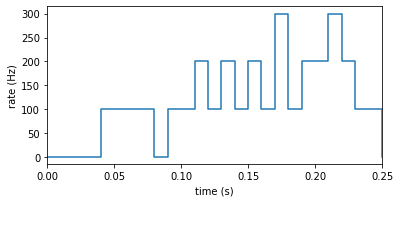

In [4]:
# time varying firing rate by counting spikes in bins
binsize = 0.01 # 10 ms window length/bins

xbin_edges = np.arange(0, stimulus_duration+binsize*2, binsize) # create array containing bin edges
firing_rate_bins = np.histogram(example_spike_train, bins = xbin_edges)[0]/binsize # histogram counts the number of
                                                                                   # occurences in a bin

# Plotting
def plotBinnedFiringRate(xbin_edges, firing_rate_bins, stimulus_duration): # create a function to reuse later
    h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1, figsize=(6,4), gridspec_kw = {'height_ratios':[10,2.5]})
    h_ax[0].step(xbin_edges[:-1], firing_rate_bins, where = 'post')

    plt.setp(h_ax[0], ylabel = 'rate (Hz)', xlabel = 'time (s)', \
             xlim =[0, stimulus_duration])# focus on stimulus duration]
    
    hideAxes(h_ax[1]) # clean up
plotBinnedFiringRate(xbin_edges, firing_rate_bins, stimulus_duration)
    

What is a 'good' bin size? What happens if we change it?

IntSlider(value=20, description='binsize (ms): ', max=20, min=2, step=2)

Button(description='Run!', layout=Layout(width='200px'), style=ButtonStyle(button_color='lightgreen'))

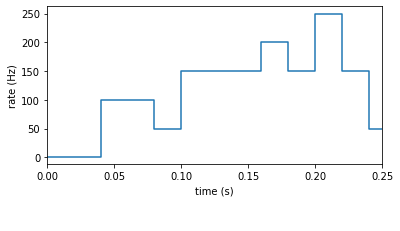

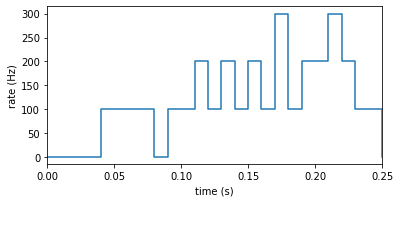

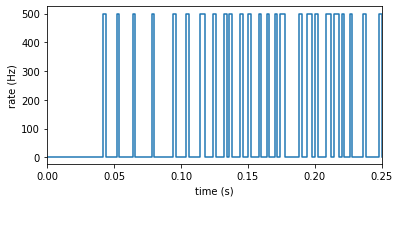

In [5]:
# time varying firing rate by counting spikes in bins
binsize = 0.01 # 10 ms bins

# Widget for the spike rate
binSlider = widgets.IntSlider(value=20, min=2, max=20, step=2, description='binsize (ms): '); 
display(binSlider);

# button to change spike rate
button = widgets.Button(description='Run!', layout=Layout(width='200px')); 
button.style.button_color = 'lightgreen'; 
display(button);

def on_button_clicked(sender): 
    binsize = binSlider.value/1000 # gather rate from slider
    
    # calculation
    xbin_edges = np.arange(0, stimulus_duration+binsize*2, binsize) # create array containing bin edges
    firing_rate_bins = np.histogram(example_spike_train, bins = xbin_edges)[0]/binsize
    
    plotBinnedFiringRate(xbin_edges, firing_rate_bins, stimulus_duration) # plotting

# run the calculation on click
button.on_click(on_button_clicked)

Recalculate the same with a much shorter bin size (20, 10, 2)

This leaves us with the question of how to decide for a bin width and the placement of the bins and really we did not get at the $r(t)$. Rather, we calculated a spike count rate in each bin and the time varying firing rate of the neuron is estimated to be constant in each bin. This also leads us to the problem that if the bin becomes small enough there is only 1 spike in each bin.

<h5> How can we get a smoothly varying firing rate $r(t)$?</h5>

Use a window function to step through the spike train and generate a continuous function.

Any windowing function that integrates to 1 can be used (dirac delta, gaussian etc.)

###### Gaussian window


Gaussian function: $ {g}(x) = \frac{1}{\sigma\sqrt{2\pi}} \operatorname{exp}\left({{{ -\frac{1}{2} \frac{\left( {x - \mu } \right)^2}{\sigma^2} }}}\right) $
<br/>
We can create a binary spike train and convolve it with the gaussian window to estimate the firing rate over time.

In [6]:
def gaussian_kernel(sigma, mu, bandwidth, dt, Tmin, Tmax):
    
    x = np.arange(Tmin, Tmax+dt, dt) 
    
    x1 = sigma * np.sqrt(2 * np.pi)
    x2 = np.exp(-(x - mu)**2/(2 * sigma**2))
    gaussian_filter = (1/x1)*x2

    bandwidth_x = np.all((x > -bandwidth/2-epsilon, x <= bandwidth/2+epsilon),0)
    gaussian_kernel = gaussian_filter[bandwidth_x] 
    
    return gaussian_kernel, x[bandwidth_x]

def convSpikeTrainWindow(spike_train_binary, window):
    # convolution with np.convolve results in a longer array than the stimulus
    convolution_full = np.convolve(spike_train_binary, window)

    window_len = len(window)
    trim_len   = int(window_len/2)
    # trim the convolved signal to signal length
    firing_rate_smooth = convolution_full[trim_len:-trim_len:]
    
    return firing_rate_smooth

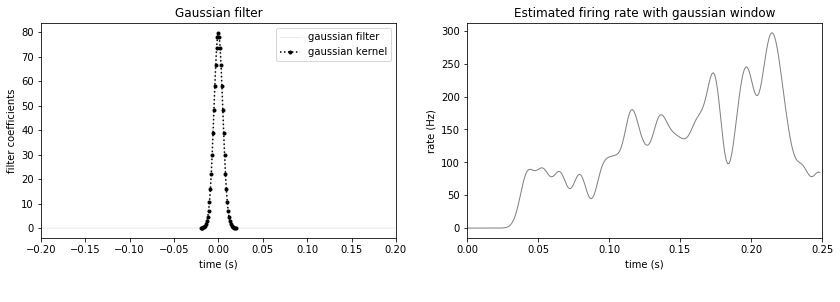

In [26]:
# Variables
sigma = 0.005
bandwidth = 0.04
mu = 0

Tmin, Tmax = -0.20, 0.20
binsize = 0.001

# use the spike count method from above to generate a binary spike train
xbin_edges_conv = np.arange(0, stimulus_duration, binsize)
spike_train_binary = np.histogram(example_spike_train, bins = xbin_edges_conv)[0]

# gaussian window
gaussian_filter, x = gaussian_kernel(sigma, mu, Tmax*2, binsize, Tmin, Tmax)
gauss_kern, gauss_x = gaussian_kernel(sigma, mu, bandwidth, binsize, Tmin, Tmax)

# calculate the convolution of the spike train and our gaussian window
firing_rate_smooth = convSpikeTrainWindow(spike_train_binary, gauss_kern)

# Plotting
h_fig, h_ax = plt.subplots(nrows = 2, ncols = 2,  gridspec_kw = {'height_ratios':[10,1.5]})
h_ax[0][0].plot(x, gaussian_filter, linewidth=0.5, color='lightgray', label = 'gaussian filter')
h_ax[0][0].plot(gauss_x, gauss_kern, ':', marker='.', color = 'black', label = 'gaussian kernel')

plt.setp(h_ax[0][0], ylabel = 'filter coefficients', title = 'Gaussian filter',\
         xlabel = 'time (s)', xlim =[Tmin, Tmax])

h_ax[0][0].legend()

h_ax[0][1].plot(xbin_edges_conv[:-1]+binsize/2, firing_rate_smooth, linewidth=1, color='gray')
plt.setp(h_ax[0][1], ylabel = 'rate (Hz)', title = 'Estimated firing rate with gaussian window',\
         xlabel = 'time (s)', xlim =[0, stimulus_duration])

hideAxes(h_ax[1]) # clean up

Let us put our spike train and various methods to calculate a time varying firing rate together.

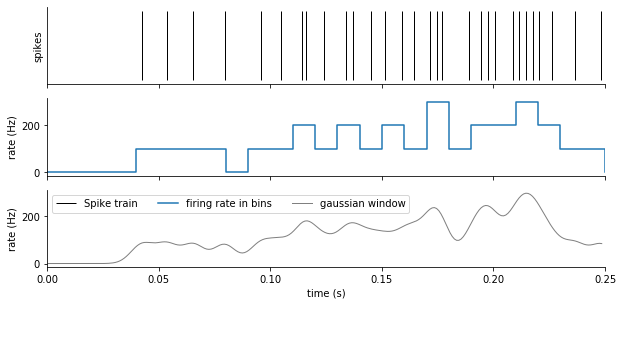

In [27]:
# Plotting
h_fig, h_ax = plt.subplots(nrows = 4, ncols = 1, figsize=(10,6), gridspec_kw = {'height_ratios':[3, 3, 3, 2]})
h_ax[0].eventplot(example_spike_train, colors='k', linelengths=0.9, linewidths=1, label=f"Spike train")
h_ax[0].set_ylabel('trial #')

plt.setp(h_ax[0], yticks = [], ylabel = 'spikes', ylim = [0.5, 1.5]) 

h_ax[1].step(xbin_edges[:-1], firing_rate_bins, where = 'post', label=f"firing rate in bins")
h_ax[1].set_ylabel('rate (Hz)')

h_ax[2].plot(xbin_edges_conv[:-1]+binsize/2, firing_rate_smooth, linewidth=1, color='gray', label=f"gaussian window")
h_ax[2].set_ylabel('rate (Hz)')
h_ax[2].set_xlabel('time (s)')

[plt.setp(cur_ax.get_xticklabels(), visible=False) for cur_ax in h_ax[0:2]]
plt.setp(h_ax[0:3], xlim = [0, stimulus_duration]) # focus on stimulus duration

[(cur_ax.spines['top'].set_visible(False), cur_ax.spines['right'].set_visible(False)) for cur_ax in h_ax[0:3]]

lines_labels = [ax.get_legend_handles_labels() for ax in h_fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
h_ax[2].legend(lines, labels, loc = 'upper left', ncol=3)

hideAxes(h_ax[3]) # clean up

### 2. Tuning curves

A tuning curve describes neuronal responses in relation to stimulus properties such as frequency, sound level etc.

Tuning curves are usually based on the presentation of multiple trials of a given stimulus. 

<img src="images/M13W1671_Raster.png" width=40% style="margin-left:auto; margin-right:auto">

Then we can expand the <strong>spike count rate</strong>: $r = n/T$ 
to multiple trials to get the <strong>average firing rate:</strong> $\langle r \rangle = \frac{\langle n \rangle}{T}$, with $\langle \cdot \rangle$ denoting the average.

The tuning curve is then the average firing rate as a function of the stimulus or stimulus property: $\langle r \rangle = f(s)$

spike trains differ between presentations: there is "noise" in spike trains
thus a stimulus gets many different spike trains seemingly randomly
the noise leads to a probabilistic formulation of how spike trains correspond to events in the world (stimuli)


Post-stimulus time histogram (PSTH): count spikes in bin, normalize by number of repetitions

gives firing rate or probability of firing per unit time (bin) as a function of time

In [9]:
def avg_firing_rate(spike_counts, duration):
        return np.mean(spike_counts)/duration

The best frequency of the neuron is 9.85 kHz


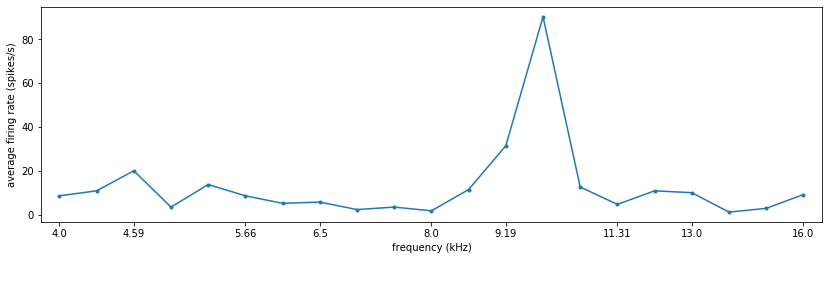

In [10]:
# load the data of a frequency tuning experiment from a thalamic neuron of an awake marmoset
stimulus_frequencies = np.loadtxt('data' + '/' + 'M13W1671_stimuli.txt', skiprows = 1) 
trials_spike_times   = np.loadtxt('data' + '/' + 'M13W1671_trials_spike_times.txt', delimiter = ',',skiprows = 1) 

# general parameters
stimulus_duration = 0.25
n_stimuli = len(stimulus_frequencies) # or unique entries in the first column of trials_spike_times
n_rep     = max(trials_spike_times[:,1])

# return unique rows consisting of a stimulus index and trial ID
un_trials = np.unique(trials_spike_times[:,[0,2]], axis = 0) 
               
# collect spike counts per trial during stimulus presentation
trial_spike_counts = np.zeros(len(un_trials))
trains_to_plot = []
for idxTrial, curTrial in enumerate(un_trials[:,1]):
    cur_trial_spike_times = trials_spike_times[trials_spike_times[:,2] == curTrial,3]
    trial_spike_counts[idxTrial] = sum((cur_trial_spike_times > 0) & (cur_trial_spike_times <= stimulus_duration))
    
    trains_to_plot.append(trials_spike_times[trials_spike_times[:,2] == curTrial,3]) # keep a reference for plotting

# calculate the average firing rate per stimulus
firing_rate = np.zeros(len(stimulus_frequencies))
for idxStim, curStim in enumerate(np.unique(un_trials[:,0])):
    firing_rate[idxStim] = avg_firing_rate(trial_spike_counts[un_trials[:,0] == curStim], stimulus_duration)    
    
# identify the peak firing rate to get the stimulus that drives the neuron best   
best_frequency = np.round(stimulus_frequencies[np.argmax(firing_rate)]/1000,2)
print(f"The {color.BOLD}best frequency{color.END} of the neuron is {best_frequency} kHz")
    
# Plotting
h_fig, h_ax = plt.subplots(nrows = 2, ncols = 1,  gridspec_kw = {'height_ratios':[10,1.5]})
h_ax[0].plot(np.arange(n_stimuli), firing_rate,".-")

# put a useful label on the abscissa
xticks = h_ax[0].get_xticks().astype(int)
xticks = xticks[(xticks >= 0) & (xticks < n_stimuli)]

plt.setp(h_ax[0], xticks = xticks, xticklabels = (np.round(stimulus_frequencies[xticks]/1000,2)),\
        ylabel ='average firing rate (spikes/s)', xlabel ='frequency (kHz)', xlim = [-0.5, n_stimuli-0.5]) 

hideAxes(h_ax[1])

Let us also create a raster plot to check our calculations:

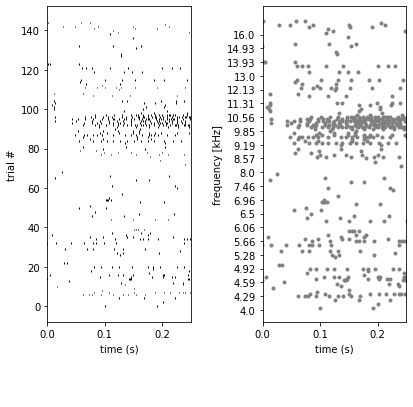

In [11]:
# Plotting
h_fig, h_ax = plt.subplots(nrows = 2, ncols = 2, figsize=(6,6), gridspec_kw = {'height_ratios':[10,1]})
h_ax[0][0].eventplot(trains_to_plot, colors='k', linelengths=0.9, linewidths=1)

h_ax[0][1].plot(trials_spike_times[:,3], trials_spike_times[:,2], linestyle = 'None', marker = '.', color='gray')

# put a useful label on the ordinate
yticks = np.arange(0,n_rep*n_stimuli,n_rep)

plt.setp(h_ax[0][1], yticks = yticks, yticklabels = np.round(stimulus_frequencies[(yticks / n_rep).astype(int)]/1000, 2),\
        ylabel = 'frequency [kHz]', xlabel = 'time (s)')
plt.setp(h_ax[0][0], ylabel = 'trial #', xlabel = 'time (s)')
plt.setp(h_ax[0], xlim = [0, stimulus_duration]) # focus on stimulus duration

plt.tight_layout()

hideAxes(h_ax[1])

##### Spike train recorded after stimulation with xxxx

- spike trains differ between presentations: __there is "noise" in spike trains__
- thus a stimulus gets many different spike trains seemingly randomly

the noise leads to a probabilistic formulation of how spike trains correspond to events in the world (stimuli)


Post-stimulus time histogram (PSTH): count spikes in bin, normalize by number of repetitions
- gives firing rate or probability of firing per unit time (bin) as a function of time

<img src="images/StimuliToResponse.png" width=50% style="margin-left:auto; margin-right:auto">

### 3. Spike train statistics


##### 3.1 A model of real spike trains: Poisson spike train

Provides a simple model of spike firing statistics.

Definition of a Poisson process: occurence of a spike occurs with some probability per unit time (rate). The rate can be time dependent but independent of occurence of other spikes.

How to recognize a <strong><em>Poisson</em></strong> process? 
- check for time interval $0$ to $T$

- Average number of spikes $\langle N \rangle$ is time integral of the firing rate: $\langle N\rangle = \int_{0}^{T}dt\,r(t)$

- Variance of spike count is equal to the mean! $\sigma^2_{N} = \langle N\rangle$

<strong><em>Fano factor</em></strong> describes the relationship of variance to the mean: $$ F = \frac{\sigma^2_{N}}{\langle N\rangle} = 1 $$



The simplest stochastic description of neuronal firing is a Poisson process.
In the cortex, the timing of successive action potentials is highly irregular.

How this set of slides is supposed to work:
    
    1. explain what a point process and the special case of the poisson process (specifically poisson process) is
    2. write down the formula for the poisson process and related factors (mean, variance, fano factor)
    3. generate code to create poisson process based spike trains
    4. test with code whether the formula are correct

###### Homogeneous poisson process

- instantaneous firing rate is constant over time $r(t) = r $
    
Thus the spike count in a time interval $\Delta t$ becomes: $$\langle N\rangle = r\Delta t$$
The variance in the time interval $\Delta t$ becomes: $$\sigma^2_{N} = r\Delta t$$

What is the probability of observing 1 spike within a small time window? $P(1\,in\, \Delta t) = r\Delta t$
if $\Delta t$ is very small, i.e. when $r\Delta t\ll 1$.


In [12]:
def poissonSpikeTrain(rate, dt, timeInterval, seed = 10):
    # generate a homogenous Poisson spike train given rate [Hz] and timestep dt [s]

    tvec = np.arange(timeInterval[0], timeInterval[1], dt) # vector of timestamps

    pspike = rate * dt # probability of generating a spike in bin/timestep
    np.random.seed(seed) # reset random number generator to reproducible state
    spk_poiss = np.random.rand(len(tvec)) # random numbers between 0 and 1
    spk_poiss_idx = spk_poiss < pspike # boolean array of bins with spike
    spk_poiss_t = tvec[spk_poiss_idx] # use boolean indexing to get corresponding spike times

    return spk_poiss_t

##### Let us verify computationally the properties of a poisson process
- generate 1000 different poisson spike trains, calculate mean, variance and Fano factor for the number of spikes in the ensemble of spike trains
- Do the values calculated fit with the expected values?

do this by changing the seed otherwise our function will always give the same spike train

do this again by adding a seed offset factor 
e.g.: ```poissonSpikeTrain(rate, dt, t, seed = idx_train))```


In [23]:
# general parameters
n_trains = 1000
dt = 0.001   # time step in seconds
t  = [0, 10] # time interval (length) of spike train to generate   
rate = 50 # firing rate of the poisson process in Hz

# generate poisson spike trains
spk_poiss_trains = []
for idx_train in range(n_trains):
    spk_poiss_trains.append(poissonSpikeTrain(rate, dt, t, seed = idx_train))

nSpikList = [len(cur_poiss_ts) for cur_poiss_ts in spk_poiss_trains] # how many spikes within each train?

# DISPLAY THE RESULTS
print(f"Average number of spikes and standard deviation of spike numbers across {n_trains} spike trains")
print(f"Given firing rate: {rate} Hz and spike train length: {max(t)} s")
print(f"Average number of spikes: {np.nanmean(nSpikList)}")
print(f"Variance:                 {np.nanstd(nSpikList)**2}")
print(f"{color.BOLD}Fano factor{color.END}: {np.nanstd(nSpikList)**2/np.nanmean(nSpikList)}")
print("\n") # trick to let jupyter notebook slides render completely in slides mode

Average number of spikes and standard deviation of spike numbers across 1000 spike trains
Given firing rate: 50 Hz and spike train length: 10 s
Average number of spikes: 501.16
Variance:                 503.77239999999995
Fano factor: 1.0052127065208714




The homogenous poisson process does not have a refractory period. So how well does this work for recorded spike trains?

Let us calculate the mean and variance of the number of spikes observed for different stimuli and plot them.

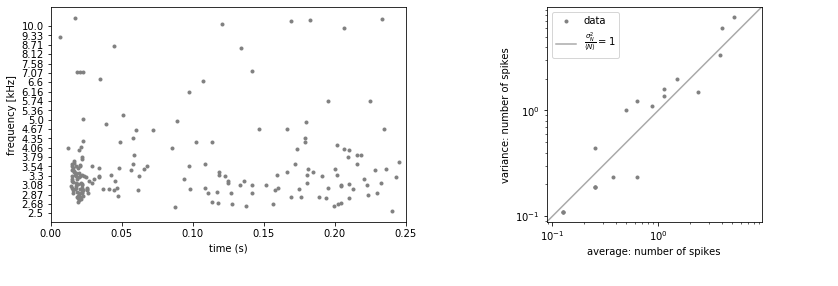

In [14]:
# let us load another example of a frequency tuning experiment
stimulus_frequencies = np.loadtxt('data' + '/' + 'M54T2710_stimuli.txt', skiprows = 1) 
trials_spike_times   = np.loadtxt('data' + '/' + 'M54T2710_trials_spike_times.txt', delimiter = ',',skiprows = 1) 

# general parameters
stimulus_duration = 0.25
n_stimuli = len(stimulus_frequencies) # or unique entries in the first column of trials_spike_times
n_rep     = int(max(trials_spike_times[:,1]))

n_trials = n_stimuli * n_rep
spike_train_stat = np.zeros((n_stimuli,2))
for curStim in range(n_stimuli):
    nSpik = np.zeros(n_rep)
    cur_stim_spike_times = trials_spike_times[np.argwhere(trials_spike_times[:,0] == curStim + 1),[1,3]]
    if cur_stim_spike_times.size > 0:
        for curRep in range(n_rep):
            cur_trial_spike_times = cur_stim_spike_times[np.argwhere(cur_stim_spike_times[:,0] == curRep + 1),1]
            if cur_trial_spike_times.size > 0:
               nSpik[curRep] = sum((cur_trial_spike_times > 0) & (cur_trial_spike_times <= stimulus_duration))
            
    spike_train_stat[curStim,:] = [np.nanmean(nSpik), np.nanstd(nSpik)**2]  

# Plotting
h_fig, h_ax = plt.subplots(nrows = 2, ncols = 2,  gridspec_kw = {'height_ratios':[10,1.5]})
h_ax[0][0].plot(trials_spike_times[:,3], trials_spike_times[:,2], \
                linestyle = 'None', marker = '.', color='gray') # raster plot of the frequency tuning experiment

# put a useful label on the ordinate
yticks = np.arange(0,n_rep*n_stimuli,n_rep)
plt.setp(h_ax[0][0], xlim = [0, stimulus_duration], xlabel = 'time (s)',\
         yticks = yticks, ylabel = 'frequency [kHz]',\
         yticklabels = np.round(stimulus_frequencies[(yticks / n_rep).astype(int)]/1000, 2))

h_ax[0][1].loglog(spike_train_stat[:,0], spike_train_stat[:,1], '.',\
                  color = 'gray',  label = "data") # plot of variance vs. mean number of spikes

xlims, ylims = h_ax[0][1].get_xlim(), h_ax[0][1].get_ylim()
ax_lims = [min(xlims[0], ylims[0]), max(xlims[1], ylims[1])]

h_ax[0][1].plot(ax_lims, ax_lims, color = 'darkgray', label = r"$\frac{\sigma^2_{N}}{\langle N \rangle} = 1$")
h_ax[0][1].legend()

plt.setp(h_ax[0][1], xlabel = 'average: number of spikes', xlim = ax_lims, ylim = ax_lims,\
         ylabel = 'variance: number of spikes', aspect = 'equal', adjustable = 'box')

hideAxes(h_ax[1]) # clean up

<strong>Poisson models of neuronal responses often provide a surprisingly good approximation especially given how simple of a model the poisson processes are.</strong>
<br/>
&#8205; 

### Summary - Spike train analysis using Python

- Firing rates<div style="float:right;"><img src="images/firingRate.png" width=180 style="margin-left:auto; margin-right:auto"></div>
<br/>
<br/>
- Tuning curves<div style="float:right;"><img src="images/tuningCurve_M13W1671.png" width=180 style="margin-left:auto; margin-right:auto"></div>
<br/>
<br/>
- Poisson models of neural spike trains<div style="float:right;"><img src="images/fanoFactor_M54T2710.png" width=180 style="margin-left:auto; margin-right:auto"></div>
<br/>

Github repository of the lecture: https://github.com/JeschkeM/LehrprobeUOL

Bonus: can you spot the bug in the firing rate evaluation code? 2nd bonus: can you fix it?


Email me: mjeschke@dpz.eu

##### Convolution


* Example: convolution of 2 rectangular functions $f(t)$ and $h(t)$ resulting in the convolved function $g(t)$

$$
\begin{align*}
f(t) &= \operatorname{rect}\left(0.5 . t\right) \\
h(t) &= \operatorname{rect}\left(0.5 . t\right) \\
\\
g(t) &= f(t) \ast h(t)
\end{align*}
$$

<img src="images/convolution.gif" width=480  style="margin-left:auto; margin-right:auto">

$$(f \ast g)[n] = 	\sum_{ m=0}^{N-1}f[m] g[n−m]  $$

Definition of convolution https://greenteapress.com/thinkdsp/html/thinkdsp009.html

Definition of linear filter in Dayan-Abbott to get time varying firing rate:

$r_{approx}(t) = \int_{-\infty}^{\infty} d\tau \omega(\tau)p(t - \tau)$